In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import random_split, DataLoader

/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/dataml200/bin/../lib/libjpeg.9.dylib' (no such file)'If yo

In [ ]:
# I'm a Mac user lol
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
            
else:
    mps_device = torch.device("mps")
    device = mps_device

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mps


In [5]:
dataset_path = './dataset_ex2' # you can change the path if you want to store the dataset somewhere else.

In [ ]:
# Load dataset
dataset = STL10(root=dataset_path, split='train', transform=transforms.ToTensor(), download=True)
train_size = 4000
test_size = 1000

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

100%|██████████| 2.64G/2.64G [04:43<00:00, 9.30MB/s] 


Extracting ./dataset_ex2/stl10_binary.tar.gz to ./dataset_ex2


In [ ]:
# Function to add noise to images
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [ ]:
# Function to show images
def imshow(img, ax, title):
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

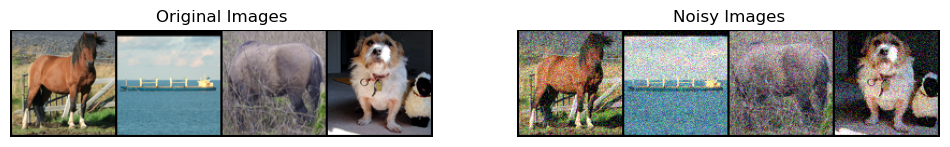

In [10]:
# Get a batch of training data
images, _ = next(iter(train_loader))
noisy_images = add_gaussian_noise(images)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
imshow(torchvision.utils.make_grid(images[:4]), axes[0], 'Original Images')
imshow(torchvision.utils.make_grid(noisy_images[:4]), axes[1], 'Noisy Images')
plt.show()

<h3>Mini U-Net to be implemented </b> </h3>


<div style="text-align: center;">
    <img src="MiniUNet.png" alt="Image Title" style="width:500px; height:auto;"/>
</div>


In [ ]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoding path
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # can be reused in the forward as it has no parameters.
        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoding path
        self.upconv1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
  

    def forward(self, x):
        """ 
        This function implements the forward pass
        
        Parameters:
            x: input images of shape (batch_size, 3, 96, 96)
        Returns: 
            denoised images of shape (batch_size, 3, 96, 96)
        """
        # encodings
        down1 = self.enc1(x)
        down2 = self.enc2(self.pool(down1))
        down3 = self.enc3(self.pool(down2))

        # decodings
        up1_conv = self.upconv1(down3)
        up1_concat = torch.cat((down2, up1_conv), dim=1) # channel concatenation
        up1_decoded = self.dec1(up1_concat)
        up2_conv = self.upconv2(up1_decoded)
        up2_concat = torch.cat((down1, up2_conv), dim=1) # channel concatenation
        up2_decoded = self.dec2(up2_concat)

        denoised = self.dec3(up2_decoded)
        return denoised


        

In [ ]:
def loss_and_optimizer(model):
    """
    This function initializes and returns the loss criterion and optimizer for training a CNN model.

    Parameters:
    model: The model to be trained.

    Returns:
    tuple: A tuple containing:
        -  The loss function (Mean Squared Error loss).
        -  The optimizer (Adam) for updating model parameters.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return criterion, optimizer
    

In [15]:
model = MiniUNet()
criterion, optimizer = loss_and_optimizer(model)

model = model.to(device) 
criterion = criterion.to(device)

In [ ]:
# Training loop

def train(model, optimizer, criterion, train_loader, num_epochs=10, verbose=True): 
    """ 
    Function to train the model.
    
    Parameters: 
    - model: The model to train.
    - optimizer: The optimizer for updating model parameters.
    - criterion: The loss function to use.
    - train_loader: DataLoader for training data.
    - num_epochs: Number of training epochs (default is 10).
    - verbose: Boolean: print training progress and loss (default is True) 
    """
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []                                  # Append the loss of every iteration to the epoch loss
        for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", disable=not verbose)):
            
            images = images.to(device)                  # Move the input to 'device' (CPU or GPU or MPS)
            noisy_images = add_gaussian_noise(images)   # Add Gaussian noise to simulate noisy images
    
            # Magic below
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_loss):.4f}') 

In [22]:
num_epochs = 10
if not skip_training:
    train_loss = train(model, optimizer, criterion, train_loader, num_epochs)
    torch.save(model.state_dict(), 'best_model.pth')
    print("Your trained model is saved successfully!")
else:
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    print("Loaded weights from your saved model successfully!")

Epoch 1/10: 100%|██████████| 500/500 [00:24<00:00, 20.58it/s]


Epoch [1/10], Loss: 0.0040


Epoch 2/10: 100%|██████████| 500/500 [00:21<00:00, 22.96it/s]


Epoch [2/10], Loss: 0.0019


Epoch 3/10: 100%|██████████| 500/500 [00:21<00:00, 22.91it/s]


Epoch [3/10], Loss: 0.0017


Epoch 4/10: 100%|██████████| 500/500 [00:21<00:00, 22.97it/s]


Epoch [4/10], Loss: 0.0017


Epoch 5/10: 100%|██████████| 500/500 [00:21<00:00, 23.00it/s]


Epoch [5/10], Loss: 0.0016


Epoch 6/10: 100%|██████████| 500/500 [00:21<00:00, 23.02it/s]


Epoch [6/10], Loss: 0.0015


Epoch 7/10: 100%|██████████| 500/500 [00:21<00:00, 23.03it/s]


Epoch [7/10], Loss: 0.0015


Epoch 8/10: 100%|██████████| 500/500 [00:21<00:00, 23.01it/s]


Epoch [8/10], Loss: 0.0015


Epoch 9/10: 100%|██████████| 500/500 [00:22<00:00, 22.21it/s]


Epoch [9/10], Loss: 0.0014


Epoch 10/10: 100%|██████████| 500/500 [00:22<00:00, 22.44it/s]

Epoch [10/10], Loss: 0.0014
Your trained model is saved successfully!


In [25]:
# Testing loop
def test(model, criterion, test_loader):
    """ 
    Function to test the model.
    
    Parameters: 
    - model: The model to test.
    - criterion: The loss function to calculate test loss.
    - test_loader: DataLoader for testing data.
    """
    model.eval()
    test_loss = []
    # YOUR CODE HERE
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            images = images.to(device)
            noisy_images = add_gaussian_noise(images)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss.append(loss.cpu())
            
    return np.mean(test_loss)

In [26]:
test_loss = test(model, criterion, test_loader)
print(f'Test loss: {test_loss:.4f}')

Test loss: 0.0015


In [29]:
def visualize_results(model, test_loader):
    """
    Function to visualize the denoiser
    Parameters:
    - model: The model to use for denoising
    - test_loader: The DataLoader for testing data
    """

    # get one batch of images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Add Gaussian noise
    noisy_images = add_gaussian_noise(images)

    #Forward pass to get the denoised images
    with torch.no_grad():
        outputs = model(noisy_images)

    # Display original, noisy, and denoised images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))               
    axs[0].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
    axs[0].set_title('Original')
    axs[1].imshow(np.transpose(noisy_images[0].cpu().numpy(), (1, 2, 0)))
    axs[1].set_title('Noisy')
    axs[2].imshow(np.transpose(outputs[0].cpu().numpy(), (1, 2, 0)))
    axs[2].set_title('Denoised')
    plt.show()
    return

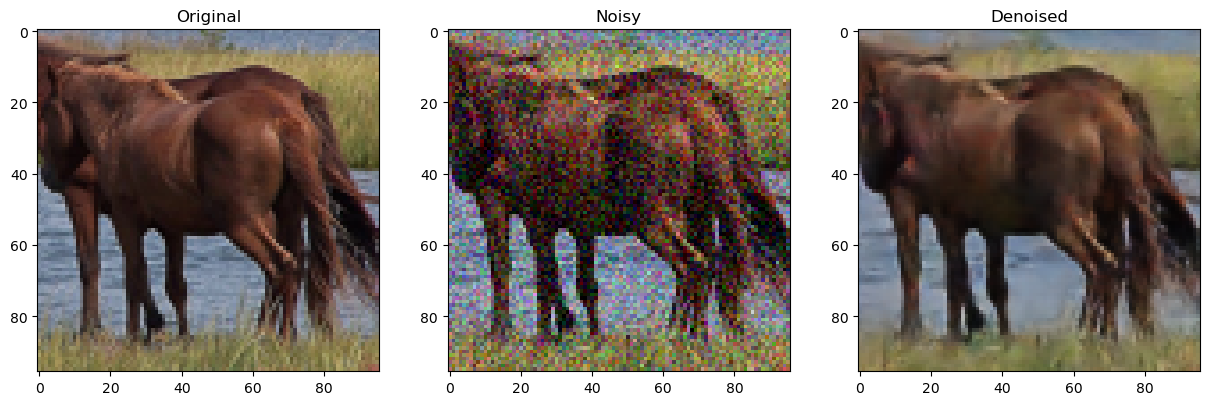

In [55]:
# visualize the results. You can run this cell multiple times to see different test images.
visualize_results(model, test_loader)